In [1]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn 
from d2l import torch as d2l

In [2]:
# 下载数据集
d2l.DATA_HUB['cifar10_tiny'] = (d2l.DATA_URL + 'kaggle_cifar10_tiny.zip', '2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')

# 如果使用完整的Kaggle竞赛的数据集，设置demo为False
demo = True
if demo:
    data_dir = d2l.download_extract('cifar10_tiny')
else:
    data_dir = '../data/cifar-10/'

In [3]:
# 整理数据集
def read_csv_labels(fname):
    """读取fname来给标签字典返回一个文件名"""
    with open(fname, 'r') as f:
        # 跳过文件头行(列名)
        lines = f.readlines()[1:]
    tokens = [l.rstrip().split(',') for l in lines]
    return dict(((name, label) for name, label in tokens))

labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
print('# 训练样本 :', len(labels))
print('# 类别 :', len(set(labels.values())))

# 训练样本 : 1000
# 类别 : 10


In [4]:
def copyfile(filename, target_dir):
    '''将文件复制到目标目录'''
    os.makedirs(target_dir, exist_ok=True)
    shutil.copy(filename, target_dir)

In [5]:
def reorg_train_valid(data_dir, labels, valid_ratio):
    """将验证集从原始的训练集中拆分出来"""
    # 训练数据集中样本最少的类别中的样本数
    n = collections.Counter(labels.values()).most_common()[-1][1]
    # 验证集中每个类别的样本数
    n_valid_per_label = max(1, math.floor(n * valid_ratio))
    label_count = {}
    for train_file in os.listdir(os.path.join(data_dir, 'train')):
        label = labels[train_file.split('.')[0]]
        fname = os.path.join(data_dir, 'train', train_file)
        copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train_valid', label))
        if label not in label_count or label_count[label] < n_valid_per_label:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'valid', label))
            label_count[label] = label_count.get(label, 0) + 1
        else:
            copyfile(fname, os.path.join(data_dir, 'train_valid_test', 'train', label))
    return n_valid_per_label

In [6]:
def reorg_test(data_dir):
    '''在预测期间整理测试集'''
    for test_file in os.listdir(os.path.join(data_dir, 'test')):
        copyfile(
            os.path.join(data_dir, 'test', test_file),
            os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')
        )

In [7]:
def reorg_cifar10_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'trainLabels.csv'))
    reorg_train_valid(data_dir, labels, valid_ratio)
    reorg_test(data_dir)

In [8]:
batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_cifar10_data(data_dir, valid_ratio)

In [9]:
# 图像增广
transform_train = torchvision.transforms.Compose([
    # 在高和宽上将图像放大到40像素的正方形
    torchvision.transforms.Resize(40),
    # 随机裁剪出一个高和宽均为40像素的正方形图像
    # 生成一个面积为原始图像面积0.64倍到1倍到小正方形
    # 然后将其缩放为高和宽均为32像素的正方形
    torchvision.transforms.RandomResizedCrop(32, scale=(0.64,1.0), ratio=(1.0,1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914,0.4822,0.4465], [0.2023,0.1994,0.2010])
])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914,0.4822,0.4465], [0.2023,0.1994,0.2010])
])

In [10]:
# 读取数据集
# train_ds, tran_valid_ds = [torchvision.datasets.ImageFolder(
#     os.path.join(data_dir, 'train_valid_test', folder),
#     transform=transform_train) for folder in ['train', 'train_valid']]

# valid_ds, test_ds = [torchvision.datasets.ImageFolder(
#     os.path.join(data_dir, 'train_valid_test', folder),
#     transform=transform_test) for folder in ['valid', 'test']]

train_valid_ds = torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', 'train_valid'),
    transform=transform_train
)
train_ds = torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', 'train'),
    transform=transform_train
)
valid_ds = torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', 'valid'),
    transform=transform_test
)
test_ds = torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', 'test'),
    transform=transform_test
)


In [11]:
train_valid_iter = torch.utils.data.DataLoader(
    train_valid_ds, batch_size, shuffle=True, drop_last=True
)
train_iter = torch.utils.data.DataLoader(
    train_ds, batch_size, shuffle=True, drop_last=True
)
valid_iter = torch.utils.data.DataLoader(
    valid_ds, batch_size, shuffle=False, drop_last=True
)
test_iter = torch.utils.data.DataLoader(
    test_ds, batch_size, shuffle=False, drop_last=False
)

In [12]:
# 定义模型
def get_net():
    num_classes = 10
    net = d2l.resnet18(num_classes, 3)
    return net

loss = nn.CrossEntropyLoss(reduction='none')

In [13]:
# 定义训练函数
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1,num_batches], legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i+1)%(num_batches//5)==0 or i==num_batches-1:
                animator.add(epoch+(i+1)/num_batches, (metric[0]/metric[2], metric[1]/metric[2], None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch+1, (None, None, valid_acc))
        scheduler.step()
    measures = ('train loss %.3f, train acc %.3f' % (metric[0]/metric[2], metric[1]/metric[2]))
    if valid_iter is not None:
        measures += ', valid acc %.3f' % valid_acc
    print(measures + '\n%.1f examples/sec on %s' % (metric[2]*num_epochs/timer.sum(), str(devices)))

train loss 0.587, train acc 0.806, valid acc 0.453
1926.2 examples/sec on [device(type='cuda', index=0)]


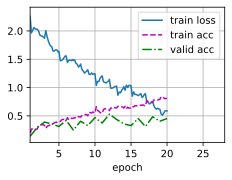

In [14]:
# 训练和验证模型
devices = d2l.try_all_gpus()
num_epochs = 20
lr = 2e-4
wd = 5e-4
lr_period = 4
lr_decay = 0.9
net = get_net()
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

train loss 0.644, train acc 0.776
1955.4 examples/sec on [device(type='cuda', index=0)]
   id     label
0   1  airplane
1   2      deer
2   3     horse
3   4      frog
4   5       dog
5   6  airplane


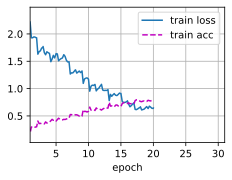

In [15]:
net, preds = get_net(), []
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period, lr_decay)
for X, _ in test_iter:
    y_hat = net(X.to(devices[0])) 
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids = list(range(1, len(test_ds) + 1)) 
sorted_ids.sort(key=lambda x: str(x))
df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.classes[x]) 
# df.to_csv('submission.csv', index=False)
print(df)